# Data preprocessing

## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_svmlight_file
from tensorflow_serving.apis import input_pb2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

## Loading data

It is necessary to download the [dataset](https://webscope.sandbox.yahoo.com) manually and decompress it. We are using folder number one for this project, which contains three files (train, test, vali) in libSVM format and text extension.

The main difficulty of the yahoo dataset is that it contains more features than the MSLR-WEB10K and the set of features for each query-document variates. Therefore, we cannot load it using read_csv, and creating a pandas dataframe reading line by line is not feasible due to computer resources.

The easiest is to load it as a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html).

Pandas permits the conversion of sparse matrices into pandas dataframe, while each column is stored as an arrays.SparseArray.

In [2]:
def from_libsvm_pandas(data_path):
    matrix = load_svmlight_file(data_path, query_id=True) 
    features = pd.DataFrame.sparse.from_spmatrix(matrix[0])    
    return features, matrix[1], matrix[2]

In [3]:
X_train, y_train, query_id_train = from_libsvm_pandas('ltrc_yahoo/set1.train.txt') 
X_test, y_test, query_id_test = from_libsvm_pandas('ltrc_yahoo/set1.test.txt')
X_val, y_val, query_id_val = from_libsvm_pandas('ltrc_yahoo/set1.valid.txt')

## Feature selection

Due to memory limitations, it is not possible to work with 699 features. In fact, many pairs query-document have less than 699 features (hence, the sparse matrix). 

We can reduce the feature space considerably by leaving out the columns that have more than 50% of zeros or values nearly to zero.

In [88]:
epsilon = 1e-6
threshold = 0.5 * len(X_train)

zero_columns = X_train.columns[(np.abs(X_train) < epsilon).sum() > threshold]

X_train = X_train.drop(zero_columns, axis=1)
X_test = X_test.drop(zero_columns, axis=1)
X_val = X_val.drop(zero_columns, axis=1)

In [89]:
print(X_train.shape)
display(X_val.head())

(473134, 196)


,10,11,16,20,26,27,29,33,35,36,...,668,670,673,676,686,689,692,693,696,698
0,0.56756,0.064688,0.073248,0.125780,0.18431,0.75984,0.75616,0.46928,0.51765,0.46008,...,0.39332,0.00000,0.46194,0.82599,0.43149,0.776530,0.93784,0.40828,0.046567,0.201640
1,0.00000,0.064688,0.035654,0.050978,0.16583,0.75984,0.00000,0.60506,0.68499,0.90748,...,0.47892,0.00000,0.00000,0.82780,0.64536,0.030142,0.00000,0.00000,0.046567,0.054559
2,0.00000,0.064688,0.041540,0.050978,0.16583,0.75984,0.00000,0.28741,0.61979,0.90748,...,0.47892,0.00000,0.00000,0.83315,0.74183,0.013032,0.00000,0.00000,0.023896,0.469010
3,0.56756,0.064688,0.275270,0.302670,0.21079,0.75984,0.72114,0.25227,0.73912,0.73840,...,0.47892,0.00000,0.65091,0.81744,0.40180,0.967590,0.98865,0.29241,0.046567,0.820420
4,0.56756,0.064688,0.013021,0.050978,0.13866,0.75984,0.70626,0.60506,0.35576,0.66609,...,0.47892,0.46792,0.39751,0.83342,0.38674,0.809340,0.85251,0.33987,0.046567,0.443740


This leaves us with 196 features for all three sets. 

To select 100 out of these 196, we run a statistic test (ANOVA) to evaluate the relationship between each feature and the target variable, and select the top k features with the highest scores. 

In [90]:
def select_features(X_train, y_train, X_val, X_test):
    
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=100)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    #transform val input data
    X_val_fs = fs.transform(X_val)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_val_fs, X_test_fs, fs

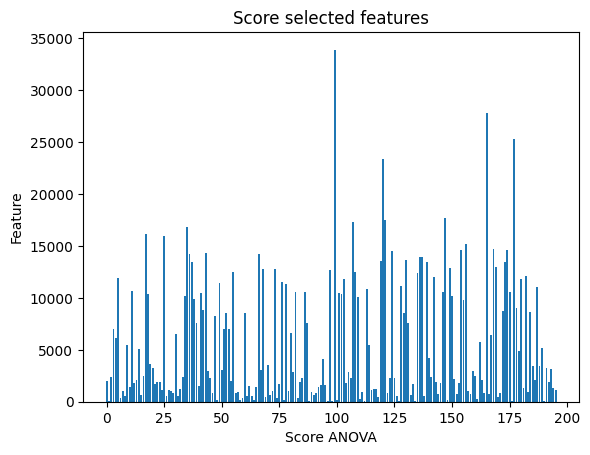

In [91]:
X_train_fs, X_val_fs, X_test_fs, fs = select_features(X_train, y_train, X_val, X_test)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title("Score selected features")
plt.xlabel("Score ANOVA")
plt.ylabel("Feature")
plt.show()

From our initial dataset of 699 features, the final 100 features selected are the following ones:

In [92]:
print(X_train.columns[fs.get_support()])

Int64Index([ 20,  26,  27,  36,  42,  68,  73,  80,  90,  97, 100, 125, 139,
            146, 148, 149, 150, 152, 153, 154, 160, 161, 166, 171, 177, 180,
            186, 191, 201, 207, 214, 240, 247, 252, 255, 264, 267, 284, 296,
            303, 304, 316, 329, 331, 349, 365, 375, 378, 380, 381, 383, 386,
            392, 394, 425, 426, 444, 445, 449, 460, 471, 473, 475, 479, 488,
            491, 493, 501, 503, 506, 520, 526, 534, 536, 541, 549, 555, 573,
            574, 578, 594, 602, 603, 604, 610, 620, 626, 630, 636, 637, 639,
            640, 646, 658, 664, 670, 673, 676, 689, 693],
           dtype='int64')


## Data visualization

### Frequency labels

To inspect the class balance of our three datasets, we can plot the labels' frequency.

In [93]:
def plot_frequency_labels(y_train, y_test, y_val):
    
    freq_train = np.bincount(y_train.astype(int))
    freq_test = np.bincount(y_test.astype(int))
    freq_val = np.bincount(y_val.astype(int))
    
    width = 0.3
    
    fig, ax = plt.subplots()
    labels = ["Bad", "Fair", "Good", "Excellent", "Perfect"]
    X_axis = np.arange(len(labels))
    
    ax.bar(X_axis, freq_train, width, label="Train", color='blue')
    ax.bar(X_axis+0.3, freq_val, width, label="Val", color='orange')
    ax.bar(X_axis+0.6, freq_test, width, label="Test", color='green')
    
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Label")
    ax.set_title("Counts by Label")
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.show()

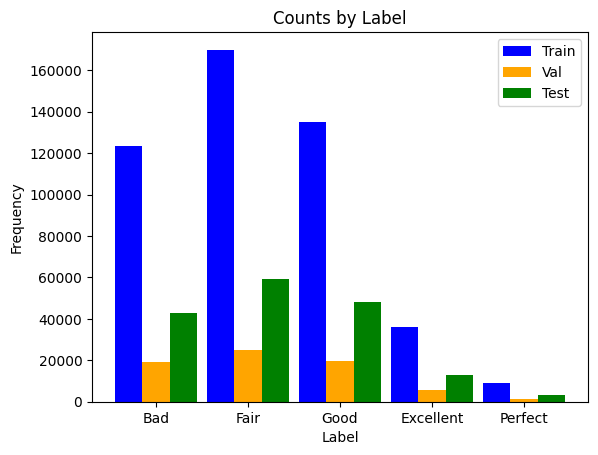

In [94]:
plot_frequency_labels(y_train, y_test, y_val)

The data is clearly imbalanced since most of the documents were labeled as "Fair", and not many as "Perfect". However, this is common in real rankings since normally there are more irrelevant documents than relevant. It also depends on the person who puntuatets the document in light of the query. Therefore, we are not applying any treatment for imbalanced data.

### Frequency queries with # documents

Another interesting plot is the number of documents retrieved against the number of queries. 

In [95]:
def plot_frequency_queries_doc(qid_train, qid_test, qid_val):   
    
    
    # Count the frequencies for each number of documents returned
    num_docs_counts_train = np.bincount(np.bincount(qid_train), minlength=1)[1:]
    num_docs_counts_test = np.bincount(np.bincount(qid_test), minlength=1)[1:]
    num_docs_counts_val = np.bincount(np.bincount(qid_val), minlength=1)[1:]

    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    # Plot 1
    axs[0].bar(np.arange(len(num_docs_counts_train)),  num_docs_counts_train, color='blue')
    axs[0].set_ylabel('Number of Documents Returned')
    axs[0].set_xlabel('Number of Queries')
    axs[0].set_title('Train')

    # Plot 2
    axs[1].bar(np.arange(len(num_docs_counts_val)), num_docs_counts_val, color='orange')
    axs[1].set_ylabel('Number of Documents Returned')
    axs[1].set_xlabel('Number of Queries')
    axs[1].set_title('Val')

    # Plot 3
    axs[2].bar(np.arange(len(num_docs_counts_test)), num_docs_counts_test, color='green')
    axs[2].set_ylabel('Number of Documents Returned')
    axs[2].set_xlabel('Number of Queries')
    axs[2].set_title('Test')

    plt.tight_layout()
    plt.show()

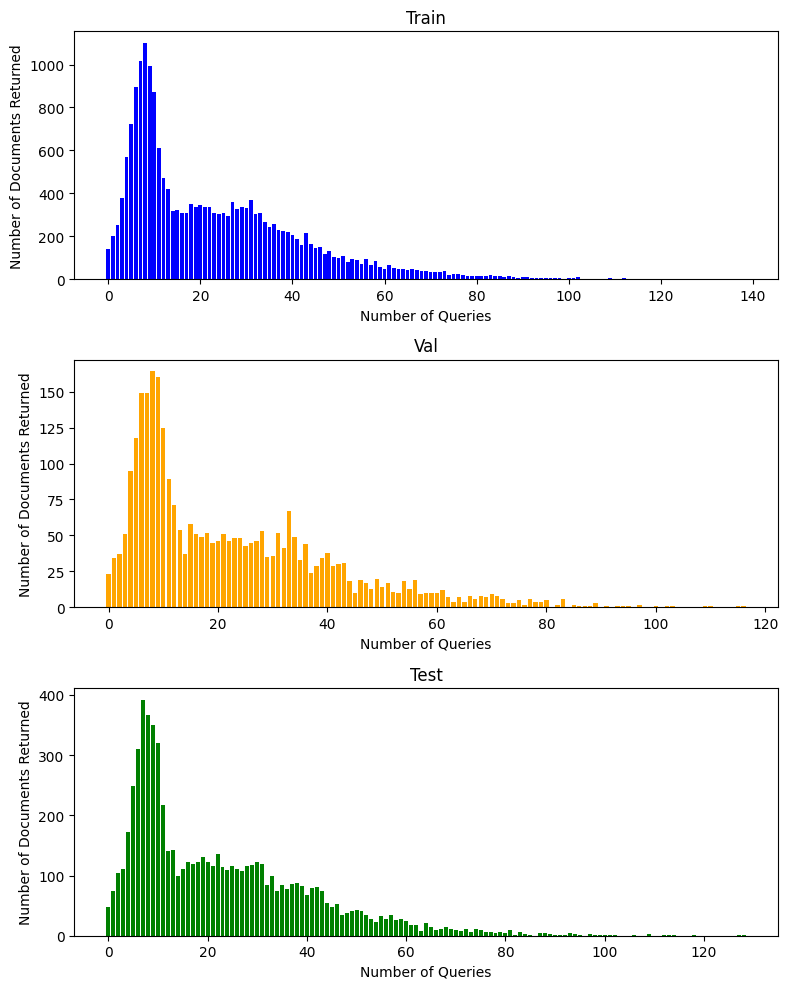

In [96]:
plot_frequency_queries_doc(query_id_train,query_id_test,query_id_val)

The sets follow a similar distribution. Most queries return between 5 and 15 documents. It is rare to find a query returning 120 documents. Hence, we are going to train our model using 50 documents per query.

### Printing statistics

In [97]:
def stats(train, test, val):
            
    # Collect metrics for below stats
    len_train = train[0].shape[0]
    len_test = test[0].shape[0]
    len_val = val[0].shape[0]
    total = len_train + len_test + len_val
        
    # Print length of all datasets and the overal balance between the splits
    print('*'*24 + ' ' + 'Total documents' + ' ' + '*'*24)
    print(f'Total documents in training set: {len_train}')
    print(f'Total documents in testing set: {len_test}')
    print(f'Total documents in validation set: {len_val}')
    print('='*64)
    print(f'The training set contains {round(len_train/total, 3)}% of the total data')
    print(f'The testing set contains {round(len_test/total, 3)}% of the total data')
    print(f'The validation set contains {round(len_val/total, 3)}% of the total data')
         
    # Mapping of initial dataframes
    dataframes = {'train': train, 'test': test, 'val': val}
        
    # Calculating the distribution of the relevance column
    for k,df in dataframes.items():
        len_docs = len(df[1])
        relevance_counts = np.bincount(df[1].astype(int))
        print('='*64)
        print('*'*16 + ' ' + f'{k} Relevance Class Balance' + ' ' + '*'*16)
        for i in [0,1,2,3,4]:
            print(f'Rank {i}: Total Count: {relevance_counts[i]} Percentage: {round(relevance_counts[i]/len_docs,3)}')
    print(' ')
    

In [98]:
train = [X_train_fs, y_train, query_id_train]
test = [X_test_fs, y_test, query_id_test]
val = [X_val_fs, y_val, query_id_val]

stats(train, test, val)

************************ Total documents ************************
Total documents in training set: 473134
Total documents in testing set: 165660
Total documents in validation set: 71083
The training set contains 0.667% of the total data
The testing set contains 0.233% of the total data
The validation set contains 0.1% of the total data
**************** train Relevance Class Balance ****************
Rank 0: Total Count: 123294 Percentage: 0.261
Rank 1: Total Count: 169897 Percentage: 0.359
Rank 2: Total Count: 134832 Percentage: 0.285
Rank 3: Total Count: 36170 Percentage: 0.076
Rank 4: Total Count: 8941 Percentage: 0.019
**************** test Relevance Class Balance ****************
Rank 0: Total Count: 42625 Percentage: 0.257
Rank 1: Total Count: 59107 Percentage: 0.357
Rank 2: Total Count: 48033 Percentage: 0.29
Rank 3: Total Count: 12804 Percentage: 0.077
Rank 4: Total Count: 3091 Percentage: 0.019
**************** val Relevance Class Balance ****************
Rank 0: Total Count: 19

In [16]:
#train = [X_train, y_train, query_id_train]
#test = [X_test, y_test, query_id_test]
#val = [X_val, y_val, query_id_val]

## Save as tfrecords

Finally, it is necessary to save the data in a specific format known as ELWC if we want to train a neural GAM model. It is one of the accepted formats of tensorflow ranking library.

In [99]:
class Parser_libSVM_tfrecord():
    
    def __init__(self, data=[], tfrecord_path=' ', labels = []):
        
        self.data = data
        self.tfrecord_path = tfrecord_path
        self.labels = labels
        
        if not os.path.isdir(self.tfrecord_path):
            os.makedirs(self.tfrecord_path)
            
    def _float_feature(self, value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    def create_tfrecord(self, data, tfrecord_path):

        options_ = tf.io.TFRecordOptions(compression_type='GZIP')
        with tf.io.TFRecordWriter(tfrecord_path) as writer:

            # Create Example list 
            elwc = input_pb2.ExampleListWithContext()
            # Save the last query id for filtering
            last_query_id = None
            
            #for each sample
            for row in range(data.shape[0]):
                # Select data from each row
                relevance_label, query_id, features = data[row,0],data[row,1],data[row,2:]
                # Create Example Dict
                example_dict = {
                   f'{feat_name}':self._float_feature(feat_val) for feat_name, feat_val in zip(self.labels, features)
                }
                example_dict['relevance_label'] = self._int64_feature(int(relevance_label))
                # Create Features
                example_ = tf.train.Example(features=tf.train.Features(
                                                         feature=example_dict)
                                     )
                # Create ELWC by query id
                if query_id != last_query_id:
                    if last_query_id != None:
                        writer.write(elwc.SerializeToString())
                    last_query_id = query_id
                    elwc = input_pb2.ExampleListWithContext()
                    elwc.examples.append(example_)
                else:
                    elwc.examples.append(example_)
            # Writing the final query
            writer.write(elwc.SerializeToString())
            
    def load_and_convert_data(self):
        # Concatenate data into one array
        # each row represents a doc, and the columns contain the label, query ID, and features
        for label, dataset in data.items():
            
            expanded_data = np.concatenate((np.expand_dims(dataset[1], axis=1), 
                                        np.expand_dims(dataset[2], axis=1), 
                                        dataset[0].toarray()), axis=1)
                                        #dataset[0].to_numpy()), axis=1)
            tfrecord_path = f'{self.tfrecord_path}/{label}.tfrecord' 
            self.create_tfrecord(expanded_data, tfrecord_path) #call function to transform into tfrecord

In [27]:
def _float_feature(value):
    """Converts a numerical value into a TensorFlow Feature object of type FloatList"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Converts a numerical value into a TensorFlow Feature object of type Int64List"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_all(examples):
    """Converts a dataframe of documents into a list of TensorFlow Example"""
    list_examples = []
    for idx, row in examples.iterrows():
        example_dict = {
            f'{feat_name}': _float_feature(feat_val) for
            feat_name, feat_val in zip(_name_features, row.iloc[2:].tolist())
        }

        example_dict['relevance_label'] = _int64_feature(int(row['relevance_label']))

        example_proto = tf.train.Example(features=tf.train.Features(feature=example_dict))
        list_examples.append(example_proto.SerializeToString())

    return list_examples

In [101]:
data = {'train':train, 'test':test, 'val':val}

yahoo_labels = ["%d" % (i + 1) for i in range(0, 100)]

parser = Parser_libSVM_tfrecord(data=data, tfrecord_path='tf_records/', labels = yahoo_labels)
parser.load_and_convert_data()

## Save test data as CSV

We also save the test data as a csv because we will need it later when we want to use LIME to generate explanations.

final_df = pd.DataFrame.sparse.from_spmatrix(test[0], columns = yahoo_labels)
final_df.insert(0, 'qid', test[2])
final_df.insert(1, 'relevance_label', test[1])
display(final_df.head())
final_df.to_csv('test_yahoo.csv', index=False)

/tmp/ipykernel_307527/3751380481.py:1: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  final_df.to_csv('test_yahoo.csv', index=False)


In [23]:
final_df = pd.read_csv('test_yahoo.csv')

In [4]:
_model_yahoo = "./model/"
#_test_yahoo = "/datasets/yahoo/test_yahoo.csv"

#_name_features = [str(i + 1) for i in range(0, 100)]

_loaded_model = tf.saved_model.load(_model_yahoo)

In [5]:
def predict_GAM(instances):
    """Predicts the documents' ranking scores using the ranking model

    Args:
        instances: pandas series of documents returned by a specific query
        idx: index (integer) of the document to explain in instances
    Returns:
        A list of scores (float) of equal length as instances
    """
    instances = serialize_all(instances)
    tf_example_predictor = _loaded_model.signatures['predict']
    scores = tf_example_predictor(tf.convert_to_tensor(instances))['output']
    return scores.numpy().flatten()

In [6]:
qids = [28587, 23068, 28700, 24240, 23890, 28483, 23132, 29379, 23022, 24923, 25000, 29889, 25191, 25207, 25226,
            28035, 28203, 28670, 28286, 28276]

In [24]:
#instances = final_df[final_df['qid'] == 28587].iloc[:, 2:].values
grouped_qid = final_df.groupby('qid')
grouped_data = grouped_qid.get_group(qids[0])

In [25]:
_name_features = [str(i + 1) for i in range(0, 100)]

<generator object DataFrame.iterrows at 0x7f3118d6ef20>

In [31]:
#docs = serialize_all(grouped_data)
per = predict_GAM(grouped_data)

In [32]:
background = grouped_data.drop(columns=['qid', 'relevance_label']).values

In [33]:
from lirme import LIRME
lirme = LIRME(background)
e_sample_size = 4000

In [34]:
def random_exp(size):
    return np.random.dirichlet(np.ones(size), size=1).flatten()

In [96]:
pointwise_exps = ['lirme', 'exs_top_k', 'exs_score', 'exs_regression', 'lime', 'shap', 'random']

In [58]:
import re
def transform_lime_exp(exp, features):
    transform_exp = np.zeros(len(features))

    for i in range(len(exp)):
        feature_idx = np.array(find_feature_idx(exp[i][0]))
        transform_exp[feature_idx] = exp[i][1]
    
    return transform_exp


def find_feature_idx(feature_rule):
    res = re.findall(r'feature_id_(\d+)', feature_rule)
    if len(res) > 0:
        return int(res[0])

    
def transform_lime_exp(exp, features):
    transform_exp = np.zeros(len(features))

    for i in range(len(exp)):
        feature_idx = np.array(find_feature_idx(exp[i][0]))
        transform_exp[feature_idx] = exp[i][1]
    
    return transform_exp


def shap_exp(instances, train_data, pred_fn, sample_size):
    sample_size_background = 100
    s = shap.sample(train_data, sample_size_background)
    explainer = shap.KernelExplainer(pred_fn, s)
    shap_exps = explainer.shap_values(instances, nsamples=sample_size)
    
    return shap_exps

def random_exp(size):
    return np.random.dirichlet(np.ones(size), size=1).flatten()


def exp_pred_fn(instance):
    _name_features = [str(i + 1) for i in range(0, 100)]
    new_sample = pd.DataFrame(instance, columns=_name_features)
    new_sample.insert(0,'relevance_label', np.repeat(0, instance.shape[0]))
    
    return predict_GAM(new_sample)
    

def lime_exp(instance, pred_fn, train_data, sample_size):
    feature_names = ['feature_id_' + str(i) for i in np.arange(train_data.shape[1])]
    lime_exp = lime_tabular.LimeTabularExplainer(train_data[:2000], 
                                             kernel_width=3, verbose=False, mode='regression',
                                             feature_names=feature_names)

    exp = lime_exp.explain_instance(instance, pred_fn, num_features=train_data.shape[1],  
                                    num_samples=sample_size)
    lime_e = exp.as_list()
    lime_e_trans = transform_lime_exp(lime_e, feature_names)
    
    return lime_e_trans

In [97]:
e_sample_size

4000

In [102]:
import pickle 
from lime import lime_tabular
import shap

e_sample_size = 3000
p_exps = {}

for key in qids:
    print('Document explanations for query', key)
    p_exps[key] = {}
    for t in pointwise_exps:
        p_exps[key][t] = {}
    
    grouped_data = grouped_qid.get_group(key)
    
    pred_q_docs = predict_GAM(grouped_data)
    
    base_rank = np.argsort(pred_q_docs)[::-1]
    explained_instance_idx = np.argwhere(base_rank == 10)[0][0]

    #instance =  grouped_data.iloc[explained_instance_idx, 1:]
    instance =  grouped_data.iloc[explained_instance_idx, 2:]
    
    l_exp = lime_exp(instance, exp_pred_fn, background, sample_size=e_sample_size)
    p_exps[key]['lime'] = l_exp
    
    s_exp = shap_exp(instance, background, exp_pred_fn, sample_size=e_sample_size)
    p_exps[key]['shap'] = s_exp
    
    instance =  grouped_data.iloc[explained_instance_idx, 1:]
    
    exp_lirme = lirme.explain(instance, predict_GAM, pred_q_docs, 
                sur_type='ridge', label_type='regression', 
                instance_idx=explained_instance_idx, top_rank=5, sample_size=e_sample_size)
    p_exps[key]['lirme'] = exp_lirme

    exp_exs_v1 = lirme.explain(instance, predict_GAM, pred_q_docs, 
                sur_type='svm', label_type='top_k_binary', 
                instance_idx=explained_instance_idx, top_rank=5, sample_size=e_sample_size)
    p_exps[key]['exs_top_k'] = exp_exs_v1

    exp_exs_v2 = lirme.explain(instance, predict_GAM, pred_q_docs, 
                sur_type='svm', label_type='score', 
                instance_idx=explained_instance_idx, top_rank=5, sample_size=e_sample_size)
    p_exps[key]['exs_score'] = exp_exs_v2

    exp_exs_v3 = lirme.explain(instance, predict_GAM, pred_q_docs, 
                sur_type='svm', label_type='regression', 
                instance_idx=explained_instance_idx, top_rank=5, sample_size=e_sample_size)
    p_exps[key]['exs_regression'] = exp_exs_v3

    p_exps[key]['random'] = random_exp(instance.shape[0] - 1)

pickle.dump(p_exps, open( "./p_exps_{}.p".format(e_sample_size), "wb" ) )

Document explanations for query 28587
Document explanations for query 23068
Document explanations for query 28700
Document explanations for query 24240
Document explanations for query 23890
Document explanations for query 28483
Document explanations for query 23132
Document explanations for query 29379
Document explanations for query 23022
Document explanations for query 24923
Document explanations for query 25000
Document explanations for query 29889
Document explanations for query 25191
Document explanations for query 25207
Document explanations for query 25226
Document explanations for query 28035
Document explanations for query 28203
Document explanations for query 28670
Document explanations for query 28286
Document explanations for query 28276


In [60]:
def subscores_GAM(instances, idx):
    """Explains the position of a document in the ranking
    using the interpretable ranking model

    Args:
        instances: pandas series of documents returned by a specific query
        idx: index (integer) of the document to explain in instances
    Returns:
        A list of subscores (float) of length number_features
    """
    acum_subscores = []
    tensors = tf.convert_to_tensor(instances)
    for fea in _name_features:
        tf_predictor = _loaded_model.signatures[fea + '_subscore']
        subscores = tf_predictor(tensors)
        acum_subscores.append(subscores['outputs'][idx])
    return tf.stack(acum_subscores).numpy().flatten()

In [64]:
ground_truth = []

for key in qids:    
    grouped_data = grouped_qid.get_group(key)
    
    pred_q_docs = predict_GAM(grouped_data)
    
    base_rank = np.argsort(pred_q_docs)[::-1]
    explained_instance_idx = np.argwhere(base_rank == 10)[0][0]

    instance =  grouped_data.iloc[explained_instance_idx, 1:]
    
    serialized = serialize_all(grouped_data)
    subscore = subscores_GAM(serialized, explained_instance_idx)
    ground_truth.append(subscore)

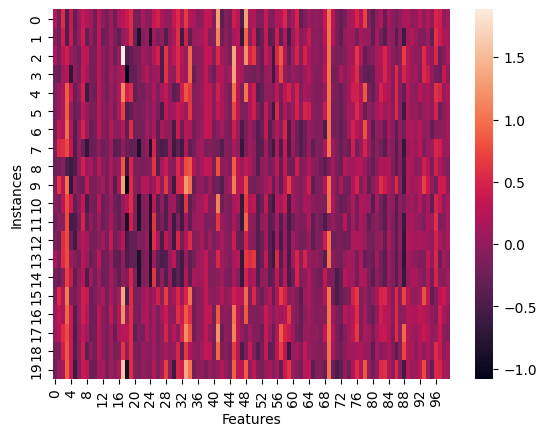

In [65]:
import seaborn as sns
sns.heatmap(ground_truth)
plt.xlabel('Features')
plt.ylabel('Instances')
plt.show()

In [66]:
from scipy.stats import rankdata

In [67]:
def calculate_metrics(gam_explanations, lime_explanations, k_top):
    """Calculates the rbo and the overlap metrics for two set of explanations

    Args:
        gam_explanations: ndarray of subscores from GAM model
        lime_explanations: ndarray of subscores from LIME
    Returns:
       rbo (float) and overlap list (floats)
    """

    ranked_GAM = rankdata([-1 * i for i in gam_explanations]).astype(int) - 1
    ranked_LIME = rankdata([-1 * i for i in lime_explanations]).astype(int) - 1
    rbo_metric = rbo(ranked_GAM, ranked_LIME, k_top)
    overlap_metric = iter_overlap(ranked_GAM, ranked_LIME)
    return rbo_metric, overlap_metric

In [68]:
import math

In [69]:
def rbo(list1, list2, p=0.9):
    """Calculates the rbo score for two equal sized ranks

    Args:
        list1: list of ranked values (integers)
        list2: list of ranked values (integers). Same length as list1
        p: weight assigned to items at different positions in the ranked lists, ranges [0,1]
    Returns:
       rbo (float)
    """
    # tail recursive helper function
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2)) / i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)

    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)

    return ((float(x_k) / k) * math.pow(p, k)) + ((1 - p) / p * summation)

def iter_overlap(list1, list2):
    """Calculates the % of overlap for two equal sized lists of ranked values in incremental sets
    of five, from 0 to number features

    Args:
        list1: list of ranked values (integers)
        list2: list of ranked values (integers). Same length as list1
    Returns:
       List of floats
    """
    list_overlap = []
    for x in range(5, len(_name_features) + 5, 5):
        included_values = [i for i in range(x)]
        indices1 = np.where(np.isin(list1, included_values))[0]
        indices2 = np.where(np.isin(list2, included_values))[0]
        inter = np.size(np.intersect1d(indices1, indices2))
        list_overlap.append(inter / x)
    return list_overlap

In [121]:
#p_exps = pickle.load( open( "p_exps_3000.p", "rb" ) )

In [127]:
from scipy.stats import kendalltau

In [180]:
eval_met = {}

for s_size in [1000, 3000, 4000]: 
    eval_met[s_size] = {}
    p_exps = pickle.load( open( "p_exps_{}.p".format(s_size), "rb" ) )
    for e in pointwise_exps:
        eval_met[s_size][e] = {}
        temp_rbo = []
        temp_over = []
        corr = []
        for i in range(len(qids)):
            q_ex = qids[i]
            rbo_, over_ = calculate_metrics(ground_truth[i], p_exps[q_ex][e], 0.95)
            corr.append(kendalltau(np.abs(ground_truth[i]), np.abs(p_exps[q_ex][e])).correlation)
            temp_rbo.append(rbo_)
            temp_over.append(over_)

        eval_met[s_size][e]['rbo'] = np.mean(temp_rbo).round(3)
        eval_met[s_size][e]['overlap'] = np.mean(temp_over).round(3)
        eval_met[s_size][e]['tau similarity'] = np.nanmean(corr).round(3)

In [228]:
pd.DataFrame(eval_met[1000])

,lirme,exs_top_k,exs_score,exs_regression,lime,shap,random
rbo,0.198,0.112,0.194,0.205,0.209,0.193,0.192
overlap,0.537,0.544,0.538,0.533,0.589,0.593,0.533
tau similarity,0.028,0.027,0.022,0.018,0.092,0.058,-0.000


In [230]:
pd.DataFrame(eval_met[3000])

,lirme,exs_top_k,exs_score,exs_regression,lime,shap,random
rbo,0.192,0.135,0.191,0.209,0.211,0.193,0.200
overlap,0.537,0.544,0.546,0.534,0.596,0.593,0.523
tau similarity,0.034,0.019,0.035,0.036,0.087,0.058,-0.038


In [231]:
pd.DataFrame(eval_met[4000])

,lirme,exs_top_k,exs_score,exs_regression,lime,shap,random
rbo,0.191,0.120,0.183,0.209,0.177,0.193,0.209
overlap,0.536,0.551,0.540,0.543,0.593,0.593,0.524
tau similarity,0.033,0.044,0.035,0.031,0.093,0.058,0.021


In [222]:
arr = []
for s_size in [1000]:
    for a in ['rbo', 'overlap', 'tau similarity']:
        arr.append((s_size, a))
    print(pd.DataFrame(eval_met[1000], multiindex=arr))

TypeError: __init__() got an unexpected keyword argument 'multiindex'

In [219]:
arr

[(1000, 'rbo'), (1000, 'overlap'), (1000, 'tau similarity')]

In [182]:
final_res = pd.concat([pd.DataFrame(eval_met[1000]), pd.DataFrame(eval_met[3000]), pd.DataFrame(eval_met[4000]), arr])

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [183]:
final_res

,lirme,exs_top_k,exs_score,exs_regression,lime,shap,random
rbo,0.198,0.112,0.194,0.205,0.209,0.193,0.192
overlap,0.537,0.544,0.538,0.533,0.589,0.593,0.533
tau similarity,0.028,0.027,0.022,0.018,0.092,0.058,-0.000
rbo,0.192,0.135,0.191,0.209,0.211,0.193,0.200
overlap,0.537,0.544,0.546,0.534,0.596,0.593,0.523
tau similarity,0.034,0.019,0.035,0.036,0.087,0.058,-0.038
rbo,0.191,0.120,0.183,0.209,0.177,0.193,0.209
overlap,0.536,0.551,0.540,0.543,0.593,0.593,0.524
tau similarity,0.033,0.044,0.035,0.031,0.093,0.058,0.021


In [144]:
|         |   lirme |   exs_top_k |   exs_score |   exs_regression |   lime |   shap |   random |
|:--------|--------:|------------:|------------:|-----------------:|-------:|-------:|---------:|
| rbo     |   0.191 |       0.12  |       0.183 |            0.209 |  0.177 |  0.193 |    0.209 |
| overlap |   0.536 |       0.551 |       0.54  |            0.543 |  0.593 |  0.593 |    0.524 |
| tau     |   0.033 |       0.044 |       0.035 |            0.031 |  0.093 |  0.058 |    0.021 |
| rbo     |   0.191 |       0.12  |       0.183 |            0.209 |  0.177 |  0.193 |    0.209 |
| overlap |   0.536 |       0.551 |       0.54  |            0.543 |  0.593 |  0.593 |    0.524 |
| tau     |   0.033 |       0.044 |       0.035 |            0.031 |  0.093 |  0.058 |    0.021 |
| rbo     |   0.191 |       0.12  |       0.183 |            0.209 |  0.177 |  0.193 |    0.209 |
| overlap |   0.536 |       0.551 |       0.54  |            0.543 |  0.593 |  0.593 |    0.524 |
| tau     |   0.033 |       0.044 |       0.035 |            0.031 |  0.093 |  0.058 |    0.021 |

Index(['rbo', 'overlap', 'tau', 'rbo', 'overlap', 'tau', 'rbo', 'overlap',
       'tau'],
      dtype='object')

 Sample Size |                |   lirme |  exs(top_k) |   exs_score |   exs_regression |   lime |   shap |   random |
:------------|:---------------|--------:|------------:|------------:|-----------------:|-------:|-------:|---------:|
             | rbo            |   0.198 |       0.112 |       0.194 |            0.205 |  0.209 |  0.193 |    0.192 |
    1000     | overlap        |   0.537 |       0.544 |       0.538 |            0.533 |  0.589 |  0.593 |    0.533 |
             | tau similarity |   0.028 |       0.027 |       0.022 |            0.018 |  0.092 |  0.058 |   -0     |
-------------|-----------------|--------:|------------:|------------:|-----------------:|-------:|-------:|---------:|
             | rbo            |   0.192 |       0.135 |       0.191 |            0.209 |  0.211 |  0.193 |    0.2   |
    3000     | overlap        |   0.537 |       0.544 |       0.546 |            0.534 |  0.596 |  0.593 |    0.523 |
             | tau similarity |   0.034 |       0.019 |       0.035 |            0.036 |  0.087 |  0.058 |   -0.038 |
-------------|-----------------|--------:|------------:|------------:|-----------------:|-------:|-------:|---------:|
             | rbo            |   0.191 |       0.12  |       0.183 |            0.209 |  0.177 |  0.193 |    0.209 |
    40000    | overlap        |   0.536 |       0.551 |       0.54  |            0.543 |  0.593 |  0.593 |    0.524 |
             | tau similarity |   0.033 |       0.044 |       0.035 |            0.031 |  0.093 |  0.058 |    0.021 |


In [198]:
arrays = [
    ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
    ["one", "two", "one", "two", "one", "two", "one", "two"],
]

In [206]:
arr = []
for s_size in [1000, 3000, 5000]:
    for a in ['rbo', 'overlap', 'tau similarity']:
        arr.append((s_size, a))
    

In [209]:
arr

[(1000, 'rbo'),
 (1000, 'overlap'),
 (1000, 'tau similarity'),
 (3000, 'rbo'),
 (3000, 'overlap'),
 (3000, 'tau similarity'),
 (5000, 'rbo'),
 (5000, 'overlap'),
 (5000, 'tau similarity')]

In [210]:
tuples = list(zip(*arr))

In [211]:
tuples

[(1000, 1000, 1000, 3000, 3000, 3000, 5000, 5000, 5000),
 ('rbo',
  'overlap',
  'tau similarity',
  'rbo',
  'overlap',
  'tau similarity',
  'rbo',
  'overlap',
  'tau similarity')]

In [216]:
final_res.reindex(arr)

reindexing with a non-unique Index is deprecated and will raise in a future version.


ValueError: cannot reindex on an axis with duplicate labels

In [214]:
final_res.set_index(arr)

KeyError: "None of [(1000, 'rbo'), (1000, 'overlap'), (1000, 'tau similarity'), (3000, 'rbo'), (3000, 'overlap'), (3000, 'tau similarity'), (5000, 'rbo'), (5000, 'overlap'), (5000, 'tau similarity')] are in the columns"

In [192]:
index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])

In [193]:
index

MultiIndex([('bar', 'one'),
            ('bar', 'two'),
            ('baz', 'one'),
            ('baz', 'two'),
            ('foo', 'one'),
            ('foo', 'two'),
            ('qux', 'one'),
            ('qux', 'two')],
           names=['first', 'second'])